In [ ]:
!pip install datasets
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval
!pip install tensorflow deepcut

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pythainlp.tokenize import word_tokenize
from datasets import load_dataset, load_metric, DatasetDict, Dataset, load_from_disk

In [ ]:
dataset = load_from_disk('/content/drive/MyDrive/Fake news/News-Dataset/dataset')

In [ ]:
def tokenizer(text):
  return word_tokenize(text,engine="deepcut")

In [ ]:
tokenizer(dataset['train']['text'][0])

['วิธี',
 'ทำ',
 'หัวปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 '|',
 '|',
 '|',
 'วิธี',
 'ทำ',
 'หัวปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 'หัว',
 'ปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 'มี',
 'วิธี',
 'ทำ',
 'รับประทาน',
 'เอง',
 'แบบ',
 'ง่าย',
 'ๆ',
 'คือ',
 'ให้',
 'เอา',
 'หัว',
 'ปลีกล้วยน้ำ',
 'ว้า',
 'เท่า',
 'นั้น',
 'หัว',
 'ปลี',
 'จาก',
 'กล้วย',
 'ชนิด',
 'อื่น',
 'ใช้',
 'ไม่',
 'ได้',
 'จำนวน',
 '1',
 'หัวย่างไฟ',
 'ให้',
 'เปลือก',
 'ชั้น',
 'นอก',
 'ไหม้',
 'เกรียม',
 'แล้ว',
 'ต้ม',
 'กับ',
 'น้ำ',
 'กะ',
 'จำนวน',
 'พอเหมาะ',
 'จน',
 'เดือด',
 'ดื่ม',
 'ต่าง',
 'น้ำ',
 'ทั้ง',
 'วัน',
 'ให้',
 'หมด',
 'หม้อ',
 'วัน',
 'ละ',
 '1',
 'หัว',
 'จน',
 'ครบ',
 '7',
 'วัน',
 'หาก',
 'คน',
 'ที่',
 'เป็น',
 'เบาหวาน',
 'ดื่ม',
 'แล้ว',
 'ถูก',
 'ทาง',
 'ยา',
 'ดื่ม',
 '1',
 '-',
 '2',
 'วัน',
 'แรก',
 'จะ',
 'มี',
 'อาการ',
 'รู้สึก',
 'ปวด',
 'เมื่อย',
 'ตาม',
 'ร่างกาย',
 'แทบ',
 'ทน',
 'ไม่',
 'ไหว',
 '

In [ ]:
#เปลี่ยนข้อความเป็น bag-of-words features
tfidf = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

In [ ]:
x_train = tfidf.fit_transform(dataset['train']['text']+dataset['valid']['text'])
x_test = tfidf.transform(dataset['test']['text'])
x_train,x_test

(<2700x74219 sparse matrix of type '<class 'numpy.float64'>'
 	with 1352829 stored elements in Compressed Sparse Row format>,
 <676x74219 sparse matrix of type '<class 'numpy.float64'>'
 	with 318216 stored elements in Compressed Sparse Row format>)

In [ ]:
enc = LabelEncoder()
y_train = enc.fit_transform(np.array(dataset['train']['labels'] + dataset['valid']['labels']))
y_valid = enc.transform(np.array(dataset['valid']['labels']))
y_test = enc.transform(np.array(dataset['test']['labels']))
y_train.shape, y_valid.shape, y_test.shape

((2700,), (270,), (676,))

In [ ]:
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LR', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['true', 'fake']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [ ]:
x_train

<2700x74219 sparse matrix of type '<class 'numpy.float64'>'
	with 1352829 stored elements in Compressed Sparse Row format>

In [ ]:
final = run_exps(x_train,y_train,x_test,y_test)

LR
              precision    recall  f1-score   support

        true       0.92      0.88      0.90       304
        fake       0.90      0.94      0.92       372

    accuracy                           0.91       676
   macro avg       0.91      0.91      0.91       676
weighted avg       0.91      0.91      0.91       676

RF
              precision    recall  f1-score   support

        true       0.88      0.86      0.87       304
        fake       0.89      0.91      0.90       372

    accuracy                           0.88       676
   macro avg       0.88      0.88      0.88       676
weighted avg       0.88      0.88      0.88       676

KNN
              precision    recall  f1-score   support

        true       0.85      0.88      0.87       304
        fake       0.90      0.88      0.89       372

    accuracy                           0.88       676
   macro avg       0.88      0.88      0.88       676
weighted avg       0.88      0.88      0.88       676

SVM
     

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

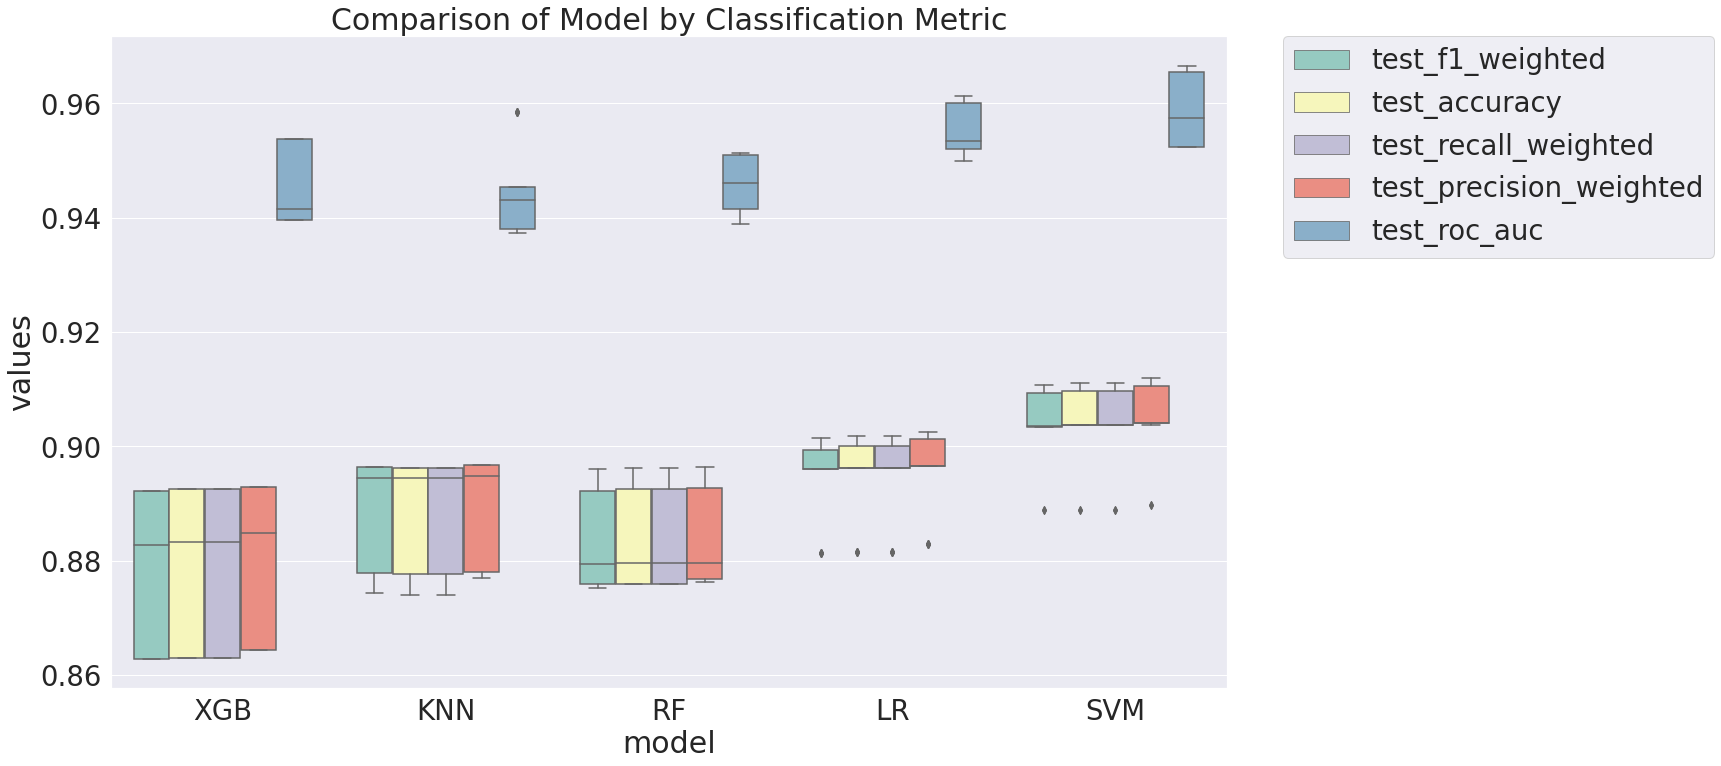

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

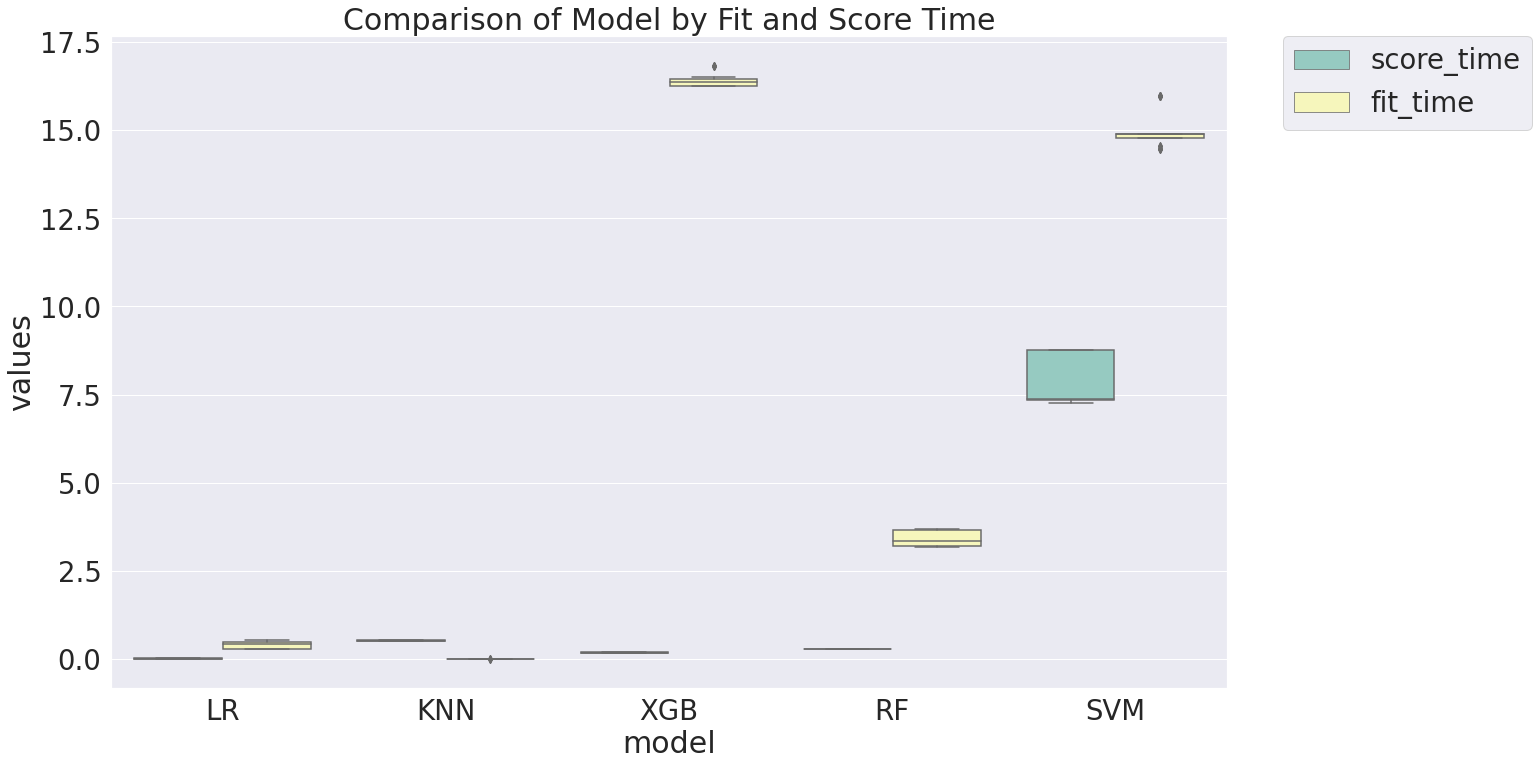

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_recall_weighted           test_f1_weighted            \
                       std      mean              std      mean   
model                                                             
KNN               0.009003  0.889938         0.008971  0.890048   
LR                0.007133  0.895000         0.006985  0.894689   
RF                0.008188  0.883272         0.008200  0.882981   
SVM               0.005392  0.905062         0.005292  0.904745   
XGB               0.012181  0.879012         0.012088  0.878590   

      test_precision_weighted           test_roc_auc           test_accuracy  \
                          std      mean          std      mean           std   
model                                                                          
KNN                  0.008597  0.890558     0.007892  0.945327      0.009003   
LR                   0.006918  0.895816     0.004173  0.954792      0.007133   
RF                   0.008057  0.883546     0.004981  0.946107      0.008188   
SVM                  0.005463  0.905668     0.006412  0.959545      0.005392   
XGB                  0.011710  0.880094     0.006019  0.944982      0.012181   

                 
           mean  
model            
KNN    0.889938  
LR     0.895000  
RF     0.883272  
SVM    0.905062  
XGB    0.879012

In [ ]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time          
            std       mean        std      mean
model                                          
KNN    0.000156   0.009674   0.013126  0.517584
LR     0.108087   0.390422   0.004063  0.012120
RF     0.208886   3.393427   0.007134  0.286035
SVM    0.506948  15.006189   0.695606  7.854571
XGB    0.184485  16.408489   0.010778  0.175549